In [1]:
import torch
from torch import nn
import torch.nn.functional as F


with open("ts_lyrics.txt", "r") as f:
  text = f.read()
print(f"length of text : {len(text)}")
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"vocab_size={vocab_size}")

# encode decode
stoi = {ch:i for i,ch in enumerate(chars)}
itos = {v:k for k,v in stoi.items()}
encode = lambda s : [stoi[i] for i in s]
decode = lambda l : "".join(itos[i] for i in l)

# !wget 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

data = torch.tensor(encode(text),dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]
print(train_data.shape , val_data.shape)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

block_size = 256
batch_size = 64
emb_size = 384
num_heads = 6
dropout = 0.2

length of text : 3956970
vocab_size=110
torch.Size([3561273]) torch.Size([395697])


In [28]:
from typing import Iterator


from torch.nn.parameter import Parameter


def get_batch(split):
  data = train_data if split == "train" else val_data
  ix = torch.randint(len(data)-block_size, (batch_size,))
  xb = torch.stack([data[i:i+block_size] for i in ix])
  yb = torch.stack([data[i+1:i+block_size+1] for i in ix])
  xb, yb = xb.to(device), yb.to(device)
  return xb, yb

@torch.no_grad()
def estimate_loss(model, eval_iters):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class LayerNorm1d(nn.Module):
    def __init__(self, n_featues, epsil= 1e-5):
        super(LayerNorm1d,self).__init__()
        self.epsil = epsil
        self.gain = torch.ones(n_featues,  device=device)
        self.bias = torch.zeros(n_featues, device=device)

    def forward(self, x):
        mean = x.mean(1,keepdim=True)
        var  = x.var(1,keepdim=True)
        self.out = self.gain*(x - mean)/torch.sqrt(var + self.epsil) + self.bias
        return self.out
    

class Head(nn.Module):
    def __init__(self, block_size, emb_size, head_size):
        super().__init__()
        self.query = nn.Linear(emb_size, head_size,bias=False,device=device)
        self.key = nn.Linear(emb_size, head_size,bias=False, device=device)
        self.value = nn.Linear(emb_size, head_size, bias=False, device=device)
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size,device=device)))

        self.dropout = nn.Dropout(dropout)      


    def forward(self, x):
        B, T, C = x.shape # C-head_size
        q = self.query(x)
        k = self.key(x)
        v = self.value(x)
        wei =  q @ k.transpose(-2,-1) * C**-0.5  # (B,T,C ) @ (B,C,T) =  (B,T,T)
        wei = wei.masked_fill(self.tril[:T,:T]==0, float('-inf'))
        wei = F.softmax(wei, dim=-1) # (B,T,T)
        wei = self.dropout(wei)
        out = wei @ v  # (B,T,T) @ (B,T,C) = B,T,C
        return out
    
    def parameters(self, recurse: bool = True) -> Iterator[Parameter]:
        return  [self.query, self.key, self.value]

class MultiHeadAttention(nn.Module):
  def __init__(self, block_size, emb_size, head_size, num_heads):
    super().__init__()
    self.heads = nn.ModuleList([Head(block_size, emb_size, head_size) for _ in range(num_heads)])
    self.dropout = nn.Dropout(dropout)

  def forward(self, x):
    out = torch.cat([h(x) for h in self.heads], dim=-1)
    out = self.dropout(out)
    return out
  

class FeedForward(nn.Module):
   
    def __init__(self, emb_size ):
      super().__init__()
      self.net = nn.Sequential(
         nn.Linear(emb_size, 4*emb_size),  # x4 output for computation
         nn.ReLU(), 
         nn.Linear(4*emb_size, emb_size),
         nn.Dropout(dropout)
      )

    def forward(self, x):
      return self.net(x)   

class Block(nn.Module):
    def __init__(self, emb_size, block_size, num_heads ):
        super().__init__()
        self.attention_heads = MultiHeadAttention(block_size, emb_size, head_size=emb_size//num_heads, num_heads=num_heads)
        self.ffwd = FeedForward(emb_size)
        self.ln1 = LayerNorm1d(emb_size)
        self.ln2 = LayerNorm1d(emb_size)

    def forward(self, x):
        x = x + self.attention_heads(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x
  
class GPTModel(nn.Module):
    def __init__(self, vocab_size, emb_size, num_heads):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, emb_size)
        self.position_embedding_table = nn.Embedding(block_size, emb_size)
        self.blocks = nn.Sequential(
           Block(emb_size, block_size, num_heads),
           Block(emb_size, block_size, num_heads),
           Block(emb_size, block_size, num_heads),
           )
        self.proj = nn.Linear(emb_size, vocab_size)

    def forward(self, x, targets=None):
        token_emb = self.token_embedding_table(x) # inp: B,T out: B,T,C 
        posi_emb = self.position_embedding_table(torch.arange(x.shape[1], device=device))  # inp: B,T out: B,T,C 
        x = token_emb + posi_emb  # B,T,C + B,T,C  
        out_heads = self.blocks(x)
        logits = self.proj(out_heads) # B,T,C --> B,T,C

        if targets is not None:
            loss = F.cross_entropy( logits.view(logits.shape[0]*logits.shape[1], logits.shape[2]), targets.view(-1)) # B*T,C cmp B*T === same batch dimension
        else:
            loss = None
        return logits, loss

    def train_model(self, optimizer, epochs=100):
        lossi = []
        for i in range(epochs):
            xb, yb = get_batch("train")
            # print(xb.device, yb.device)
            logits, loss = self.forward(xb, yb)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            lossi.append(loss.item())
            optimizer.step()
            if(i%(epochs//10) == 0):
                print(f"epochs : {i}, loss : {loss.item()}")

        print("training completed")
        return lossi

    def generate(self, idx, max_new_tokens= 1):
        # self.train()
        for i in range(max_new_tokens):
            logits, loss = self(torch.tensor([idx], dtype=torch.long, device=device))
            logc = logits[:,-1,:]
            probs = F.softmax(logc, dim=-1)
            pred = torch.multinomial(probs, num_samples=1, replacement=True)
            # print(pred)
            idx = idx[1:] + [pred.item()]
            # print(idx)
            print(decode([pred.item()]), end="")
        # self.eval()

In [30]:
model = GPTModel(vocab_size, emb_size, num_heads)
m = model.to(device)
print(sum(p.numel() for p in m.parameters()), 'parameters')
# print(next(m.parameters()).device)
optim = torch.optim.AdamW(m.parameters(), lr=3e-4)

5054702 parameters


In [31]:
ls = m.train_model(optimizer=optim, epochs=100) 

epochs : 0, loss : 5.081465721130371
epochs : 10, loss : 2.9975175857543945
epochs : 20, loss : 2.816222906112671
epochs : 30, loss : 2.7217464447021484
epochs : 40, loss : 2.598987340927124
epochs : 50, loss : 2.5733702182769775
epochs : 60, loss : 2.5442352294921875
epochs : 70, loss : 2.523676872253418
epochs : 80, loss : 2.486051559448242
epochs : 90, loss : 2.4949402809143066
training completed


In [22]:
losses = estimate_loss(m, 100)
print(losses)

{'train': tensor(1.2040), 'val': tensor(1.1993)}


In [26]:
def generate(model : nn.Module, idx, max_new_tokens= 1):
    model.eval()
    for i in range(max_new_tokens):
        logits, loss = model(torch.tensor([idx], dtype=torch.long, device=device))
        logc = logits[:,-1,:]
        probs = F.softmax(logc, dim=-1)
        pred = torch.multinomial(probs, num_samples=1, replacement=True)
        # print(pred)
        idx = idx[1:] + [pred.item()]
        # print(idx)
        print(decode([pred.item()]), end="")
    model.train()

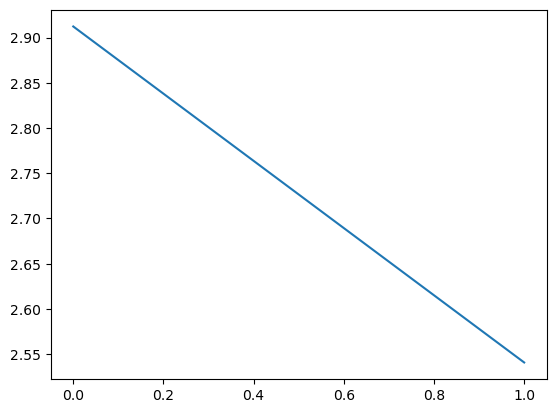

In [32]:
import matplotlib.pyplot as plt
plt.plot(torch.tensor(ls).view(-1,50).mean(1))

In [27]:
generate(m, encode(text[:block_size]),max_new_tokens= 1000)

ouster, you fivital, ah-ah, I'm fight, blue
What I'm gonna take you could off my Ways and it with one this
(It's dramn, "Fillow I'm the black
The love you wants fake, I used
Ooh, I love wish a was in your time
I'm you
They (I might just callated you will of found
Havating (Stay)
I'm still girl who break it you (Yeah)
Ah, you (Doling what I'm with you (Ooh)
I'm askund (Baby, baby, with (Hah)
[Outro]
"I could you wants paying (I'm so stay?)

[Bridge])
Hey, I'm (Making)

[Post-Chorus]
I swinuld you (Ou, I wild)
Oh, I love (I'm down (Oh)
I'm fingal
(Stay)  Babe) the passently (Out)
Like I gets my back highs
Oncage" (If I, but) where I say
I'm the kMiss (Wilda)

I'm a gIstard (Isanding to talk (Rud), get (I, I)

[Bridge])

[Outro]
(Oh) I wish place, on (I was stay)
& I watched a girl
Ah, Gidda joyst my disk (I, I)
But I have breaking (Baby)
You wanna stall the must girl six (Familyar (I-I-I)
Oh)

(And ut of the diside

[Chorus]
Stay was me, you (Bab), I can't (Yeah, I'm faun it J (In) Bridg

In [29]:
torch.save(m.state_dict(), "saved_models/taylor_gpt.pt" )

In [63]:
checkpoint = torch.load("saved_models/final_gpt.pt", weights_only=True)
new_model = GPTModel(vocab_size, emb_size, num_heads)
new_model.load_state_dict(checkpoint)
m2 = new_model.to(device)

In [64]:
generate(m2, encode(text[:block_size]),max_new_tokens= 1000)


Can noblene, of I probe cleasore: of Jainerad for thushumband on child,--agen.

Leaver Here maidsto Can the Lep My hearkrery
With bove fir conswill obat.

ESCK:
Fon't it of Henfolenory us dick of The nowacamper for thy Lord's vices;
And whom flame, Youranne
When we un hold hath tist.

PERDITABR:
And deair poweary, as none theraze;
eve fee--'It the be make meatter's vany spolakion'd Did sof MOPSTAUS:
How in away
efastes teduche words deid injust, burst.

aft kning
Of have more to such up be,
I was your begut thin, in I casse buchas,
Stre't.

DUKE VINCENTIO:
Marcious sto; thisteds.

Aspakele.

PERDINCETES:
O thainks aree Camenget Lo?

Firships KI:
Them we do scape sint; doter guet ousa!

QUEEEN Trangen now, as nother coffect.

Fit, upon gix'ear smulled, and his himseldeards!
I ser, onfearsul unclest Ladking Heis cursed lookiol, father,
For pretonamain is of thusave of Rembs that he will.

GLORUCHIFFO:
Let if ar he?; apland ineed the discrave kinst land!
Frushangest in quoke in honous th